# Image Generation - General Workflow
This notebook will highlight the decision process behind the image generation that is used to predict the last 3 frames of the surprise storm. Since we have to restart the kernel every time we start a new run, this is a discussion of the various results without the live outputs. Instead, this will be a summary of the code that was used to generate the visual outputs that will be demonstrated. 

### Different Image Generation Approaches
When thinking aobut how to generate the different images, we concluded that there would be 2 different approaches that would make sense:
* Generate 3 images in one go, as in, for a given sequence, predict 3 images ahead.
* Generate 1 image at a time, as in, for a given sequence, predict 1 image ahead, and then use that image to predict the next one, and so on.

#### Approach 1: Generating three images at a time
Below is the code for the first approach, where you can see the 3 outputted images. This involved customising the neural network to output 3 images at once.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torch.optim import Adam
from torchvision import transforms
from prediction import HurricaneDataset, Seq2Seq

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
storms = ['fgi', 'gme', 'pjj']
hurricane_dataset = ConcatDataset([HurricaneDataset(image_folder=f'gdrive/MyDrive/images_and_data/{storm}', image_size=(64, 64), channels=1) for storm in storms])


train_size = int(0.8 * len(hurricane_dataset))
val_size = len(hurricane_dataset) - train_size

train_dataset = Subset(hurricane_dataset, range(train_size))
val_dataset = Subset(hurricane_dataset, range(train_size, len(hurricane_dataset)))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [ ]:
model = Seq2Seq(num_channels=1, num_kernels=64,
kernel_size=(3, 3), padding=(1, 1), activation="relu",
frame_size=(64, 64), num_layers=3).to(device)

optim = Adam(model.parameters(), lr=1e-4)

criterion = nn.L1Loss(reduction='sum')

In [ ]:
def train_model_with_plot(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, device=device):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for input_sequence, target_sequence in train_loader:
            input_sequence = input_sequence.to(device)
            target_sequence = target_sequence.to(device)

            optimizer.zero_grad()
            output_sequence = model(input_sequence)
            loss = criterion(output_sequence, target_sequence)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for input_sequence, target_sequence in val_loader:
                input_sequence = input_sequence.to(device)
                target_sequence = target_sequence.to(device)

                output_sequence = model(input_sequence)
                val_loss += criterion(output_sequence, target_sequence).item()

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))

        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.8f}, Validation Loss: {val_loss / len(val_loader):.8f}")


train_model_with_plot(model, train_loader, val_loader, criterion, optim, num_epochs=20)

In [ ]:
def load_and_preprocess_image(image_path, image_size=(64, 64)):
    image = Image.open(image_path).convert('L')
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
    ])
    return transform(image)

In [ ]:
def predict_next_images(model, initial_images, num_predictions=3):
    current_sequence = torch.stack(initial_images, dim=1).to(device)
    predicted_images = []

    for _ in range(num_predictions):
        with torch.no_grad():
            predicted_image = model(current_sequence.unsqueeze(0)).squeeze(0)
            new_image = predicted_image[-1, :, :].unsqueeze(0).unsqueeze(0)
            current_sequence = torch.cat((current_sequence[:, 1:, :, :], new_image), dim=1)
            predicted_images.append(new_image.squeeze(0).cpu())
    return predicted_images

def get_last_images(directory, num_images=15):
    """Get the last 'num_images' JPG files from the specified directory."""
    all_files = [f for f in sorted(os.listdir(directory)) if f.endswith('.jpg')]
    return all_files[-num_images:]

image_directory = ''
image_paths = [os.path.join(image_directory, f) for f in get_last_images(image_directory)]
initial_images = [load_and_preprocess_image(path) for path in image_paths]

predicted_images = predict_next_images(model, initial_images)

# Display the predicted images
for i, img in enumerate(predicted_images):
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Predicted Image {i+1}")
    plt.show()

![Loss](images/lossfunc.jpg)

Image can be found under images_image_workflow/lossfunc.jpg

![Image](images/image2.jpeg)

Image can be found under images_image_workflow/image2.jpg

#### Approach 2: Generating one image at a time

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
storms = ['fgi', 'gme', 'pjj']
hurricane_dataset = ConcatDataset([HurricaneDataset(image_folder=f'images/{storm}', image_size=(64, 64), channels=1) for storm in storms ])


train_size = int(0.8 * len(hurricane_dataset))
val_size = len(hurricane_dataset) - train_size

train_dataset = Subset(hurricane_dataset, range(train_size))
val_dataset = Subset(hurricane_dataset, range(train_size, len(hurricane_dataset)))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [ ]:
model = Seq2Seq(num_channels=1, num_kernels=64,
kernel_size=(3, 3), padding=(1, 1), activation="relu",
frame_size=(64, 64), num_layers=3).to(device)

optim = Adam(model.parameters(), lr=1e-4)

criterion = nn.L1Loss(reduction='sum')

In [ ]:
def predict_next_images(model, initial_images, num_predictions=3):
    current_sequence = torch.stack(initial_images, dim=1).to(device)
    predicted_images = []

    for _ in range(num_predictions):
        with torch.no_grad():
            predicted_image = model(current_sequence.unsqueeze(0)).squeeze(0)
            new_image = predicted_image[-1, :, :].unsqueeze(0).unsqueeze(0)
            current_sequence = torch.cat((current_sequence[:, 1:, :, :], new_image), dim=1)
            predicted_images.append(new_image.squeeze(0).cpu())
    return predicted_images

image_directory = ''
image_paths = [os.path.join(image_directory, f) for f in get_last_images(image_directory)]
initial_images = [load_and_preprocess_image(path) for path in image_paths]

predicted_images = predict_next_images(model, initial_images)

for i, img in enumerate(predicted_images):
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Predicted Image {i+1}")
    plt.show()

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
    image_name = f"predicted_image_128_{i+1}_{timestamp}.jpg"
    save_image(img, os.path.join('outputs/', image_name))

![imagemany](images/imagemany.jpg)

Image can be found under images_image_workflow/imagemany.jpg

## Different Neural Network Architectures (Layers)
We also experimented with different neural network architectures for our ConvLSTM to see which one would give us the best results. Specifically, we added a ResNet50 layer to the ConvLSTM to see if it would improve the results since its particularly good at finding specific patterns in images that a simple ConvLSTM might not notice because clouds can take very different shapes and faint clouds in the background could become relevant in the foreground later.

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from .convlstmimage import ConvLSTMImage


class Seq2SeqImage(nn.Module):

    def __init__(self, num_channels, num_kernels, kernel_size, padding,
                 activation, frame_size, num_layers):

        super(Seq2SeqImage, self).__init__()

        # Initialize ResNet50
        self.resnet50 = models.resnet50(pretrained=True)
        self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])
        
        self.sequential = nn.Sequential()

        resnet50_output_channels = 2048 

        # Add First layer (Different in_channels than the rest)
        self.sequential.add_module(
            "convlstm1", ConvLSTMImage(
                in_channels=resnet50_output_channels, out_channels=num_kernels,
                kernel_size=kernel_size, padding=padding,
                activation=activation, frame_size=frame_size)
        )

        self.sequential.add_module(
            "batchnorm1", nn.BatchNorm3d(num_features=num_kernels)
        )

        # Add rest of the layers
        for _ in range(2, num_layers + 1):
            self.sequential.add_module(
                f"convlstm{_}", ConvLSTMImage(
                    in_channels=num_kernels, out_channels=num_kernels,
                    kernel_size=kernel_size, padding=padding,
                    activation=activation, frame_size=frame_size)
            )

            self.sequential.add_module(
                f"batchnorm{_}", nn.BatchNorm3d(num_features=num_kernels)
            )

        # Add Convolutional Layer to predict output frame
        self.conv = nn.Conv2d(
            in_channels=num_kernels, out_channels=num_channels,
            kernel_size=kernel_size, padding=padding)

    def forward(self, X):
        X = self.resnet50(X) # Pass through ResNet50
        output = self.sequential(X)

        # Return only the last output frame
        output = self.conv(output[:, :, -1])

        return nn.Sigmoid()(output)

In [ ]:
storms = ['fgi', 'gme', 'pjj']
hurricane_dataset = ConcatDataset([HurricaneDataset(image_folder=f'images/{storm}', image_size=(64, 64), channels=1) for storm in storms ])


train_size = int(0.8 * len(hurricane_dataset))
val_size = len(hurricane_dataset) - train_size

train_dataset = Subset(hurricane_dataset, range(train_size))
val_dataset = Subset(hurricane_dataset, range(train_size, len(hurricane_dataset)))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [ ]:
model = Seq2SeqImage(num_channels=1, num_kernels=64,
kernel_size=(3, 3), padding=(1, 1), activation="relu",
frame_size=(64, 64), num_layers=3).to(device)

optim = Adam(model.parameters(), lr=1e-4)

In [ ]:
def train_model_with_plot(model, train_loader, val_loader, criterion, optim, num_epochs=25, device=device):

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss = 0
        model.train()
        for input, target in train_loader:
            input, target = input.to(device), target.to(device)
            optim.zero_grad()
            output = model(input)
            loss = criterion(output.flatten(), target.flatten())
            loss.backward()
            optim.step()

            train_loss += loss.item()
        train_loss /= len(train_loader)

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for input, target in val_loader:
                input, target = input.to(device), target.to(device)

                output = model(input)
                loss = criterion(output.flatten(), target.flatten())
                val_loss += loss.item()
        val_loss /= len(val_loader)

        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}")


train_model_with_plot(model, train_loader, val_loader, criterion, optim, num_epochs=20)

![Screenshot 2024-02-02 at 14.57.43.jpg](<attachment:Screenshot 2024-02-02 at 14.57.43.jpg>)
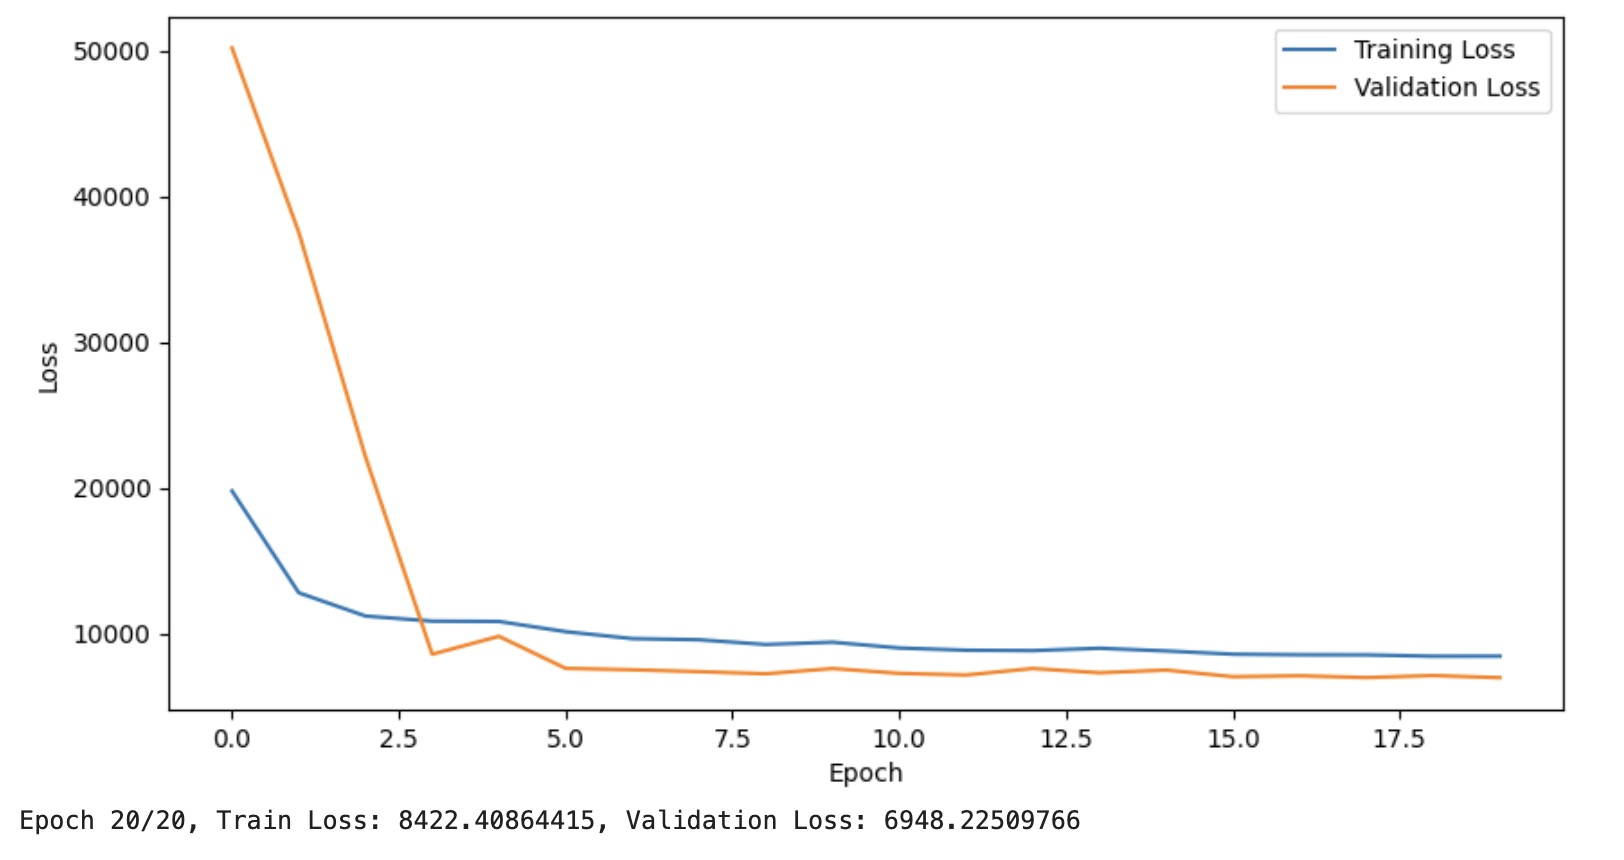

![Screenshot 2024-02-02 at 14.58.37.jpg](<attachment:Screenshot 2024-02-02 at 14.58.37.jpg>)
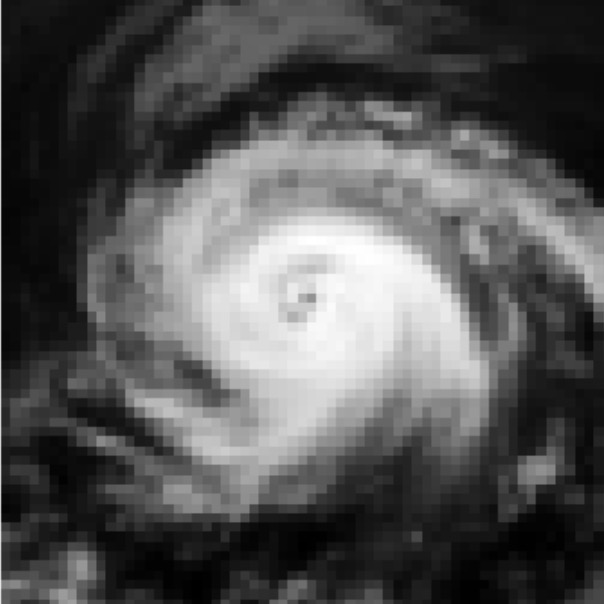

Compared to the storm in the previous example where we observed generating an image at a time, the image above does look decently better. However, the computational intenstiy was significantly higher and the results were not significantly better enough to choose it over a simple ConvLSTM.

## Different Storm Inputs
Based on the k-means algorithm in the EDA, we chose to train the model on the clusters that were generated. This was done to reduce the dimensionality of the data and to make the model more robust to similar cloud shapes. This would also be useful for the model to generalise better data.

In the following runs, we run a model on 5 dataset and later 1 dataset. We compare the image quality and thereby the model performance.

In [ ]:
storms = ['fgi']
hurricane_dataset = ConcatDataset([HurricaneDataset(image_folder=f'images/{storm}', image_size=(64, 64), channels=1) for storm in storms ])


train_size = int(0.8 * len(hurricane_dataset))
val_size = len(hurricane_dataset) - train_size

train_dataset = Subset(hurricane_dataset, range(train_size))
val_dataset = Subset(hurricane_dataset, range(train_size, len(hurricane_dataset)))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [ ]:
model = Seq2Seq(num_channels=1, num_kernels=64,
kernel_size=(3, 3), padding=(1, 1), activation="relu",
frame_size=(64, 64), num_layers=3).to(device)

optim = Adam(model.parameters(), lr=1e-4)

criterion = nn.L1Loss(reduction='sum')

In [ ]:
def load_and_preprocess_image(image_path, image_size=(64, 64)):
    image = Image.open(image_path).convert('L')
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
    ])
    return transform(image)

In [ ]:
def predict_next_images(model, initial_images, num_predictions=3):
    current_sequence = torch.stack(initial_images, dim=1).to(device)
    predicted_images = []

    for _ in range(num_predictions):
        with torch.no_grad():
            predicted_image = model(current_sequence.unsqueeze(0)).squeeze(0)
            new_image = predicted_image[-1, :, :].unsqueeze(0).unsqueeze(0)
            current_sequence = torch.cat((current_sequence[:, 1:, :, :], new_image), dim=1)
            predicted_images.append(new_image.squeeze(0).cpu())
    return predicted_images

def get_last_images(directory, num_images=15):
    """Get the last 'num_images' JPG files from the specified directory."""
    all_files = [f for f in sorted(os.listdir(directory)) if f.endswith('.jpg')]
    return all_files[-num_images:]

image_directory = ''
image_paths = [os.path.join(image_directory, f) for f in get_last_images(image_directory)]
initial_images = [load_and_preprocess_image(path) for path in image_paths]

predicted_images = predict_next_images(model, initial_images)

# Display the predicted images
for i, img in enumerate(predicted_images):
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Predicted Image {i+1}")
    plt.show()

![Screenshot 2024-02-02 at 14.58.07.jpg](<attachment:Screenshot 2024-02-02 at 14.58.07.jpg>)
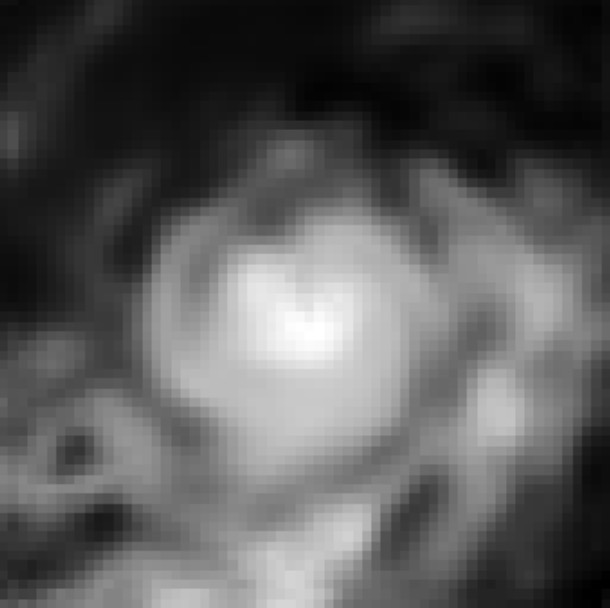

### Training with several storms

In [ ]:
storms = ['fgi', 'gkf', 'ing', 'ojv', 'pvj']
hurricane_dataset = ConcatDataset([HurricaneDataset(image_folder=f'images/{storm}', image_size=(64, 64), channels=1) for storm in storms ])


train_size = int(0.8 * len(hurricane_dataset))
val_size = len(hurricane_dataset) - train_size

train_dataset = Subset(hurricane_dataset, range(train_size))
val_dataset = Subset(hurricane_dataset, range(train_size, len(hurricane_dataset)))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [ ]:
model = Seq2Seq(num_channels=1, num_kernels=64,
kernel_size=(3, 3), padding=(1, 1), activation="relu",
frame_size=(64, 64), num_layers=3).to(device)

optim = Adam(model.parameters(), lr=1e-4)

criterion = nn.L1Loss(reduction='sum')

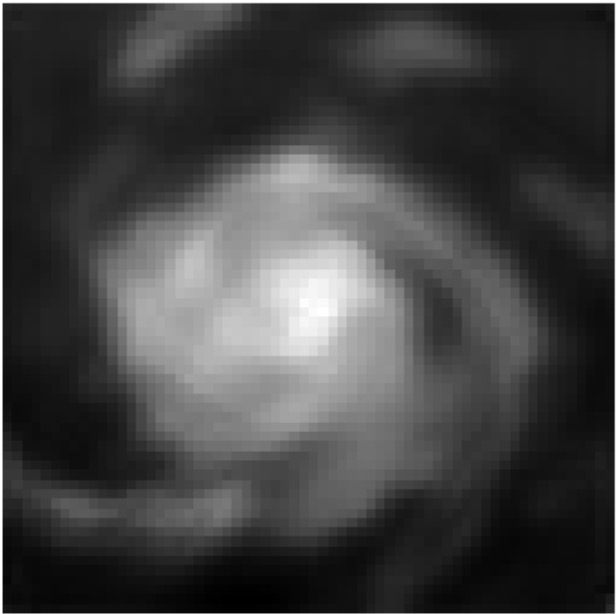

Although the result for 5 storms looks good, the training time is not computationally efficient and doesn't outweight the additional accuracy. For the sake of the project, we decided to stick with training with 3 storms, since that achieved a good trade off between quality and training time.

## Hyperparamater Tuning
We are going to observe the changes in learning rate, batch size, and number of epochs to see how they affect the model performance. We will also observe the changes in the model performance and thereby deduce the method that gives the best results for the storm prediction.

### 1. Learning rate (1e-4 vs. 2e-4)

#### Learning rate = 1e-4

In [ ]:
storms = ['fgi', 'gkf'] # MANY
hurricane_dataset = ConcatDataset([HurricaneDataset(image_folder=f'images/{storm}', image_size=(64, 64), channels=1) for storm in storms ])


train_size = int(0.8 * len(hurricane_dataset))
val_size = len(hurricane_dataset) - train_size

train_dataset = Subset(hurricane_dataset, range(train_size))
val_dataset = Subset(hurricane_dataset, range(train_size, len(hurricane_dataset)))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [ ]:
model = Seq2Seq(num_channels=1, num_kernels=64,
kernel_size=(3, 3), padding=(1, 1), activation="relu",
frame_size=(64, 64), num_layers=3).to(device)

optim = Adam(model.parameters(), lr=1e-4)

criterion = nn.L1Loss(reduction='sum')

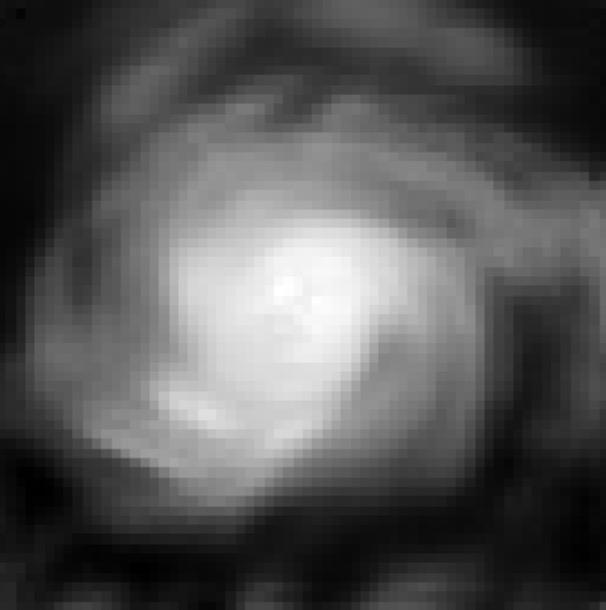

#### Learning rate = 2e-4

In [ ]:
storms = ['fgi', 'gkf', 'pjj']
hurricane_dataset = ConcatDataset([HurricaneDataset(image_folder=f'images/{storm}', image_size=(64, 64), channels=1) for storm in storms ])


train_size = int(0.8 * len(hurricane_dataset))
val_size = len(hurricane_dataset) - train_size

train_dataset = Subset(hurricane_dataset, range(train_size))
val_dataset = Subset(hurricane_dataset, range(train_size, len(hurricane_dataset)))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [ ]:
model = Seq2Seq(num_channels=1, num_kernels=64,
kernel_size=(3, 3), padding=(1, 1), activation="relu",
frame_size=(64, 64), num_layers=3).to(device)

optim = Adam(model.parameters(), lr=2e-4)

criterion = nn.L1Loss(reduction='sum')

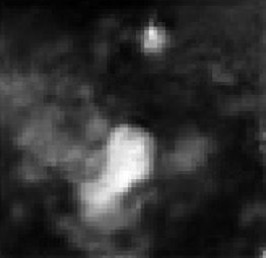

Although hard to gauge, I have found that a learnign rate of 2e-4 gives better results than 1e-4. This is because the loss function is lower and the image quality is better. Additionally, the training time is also lower.

### 2. Batch size (8 vs. 16)
#### Batch size = 8

In [ ]:
storms = ['fgi', 'gkf', 'pjj']
hurricane_dataset = ConcatDataset([HurricaneDataset(image_folder=f'images/{storm}', image_size=(64, 64), channels=1) for storm in storms ])


train_size = int(0.8 * len(hurricane_dataset))
val_size = len(hurricane_dataset) - train_size

train_dataset = Subset(hurricane_dataset, range(train_size))
val_dataset = Subset(hurricane_dataset, range(train_size, len(hurricane_dataset)))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [ ]:
model = Seq2Seq(num_channels=1, num_kernels=64,
kernel_size=(3, 3), padding=(1, 1), activation="relu",
frame_size=(64, 64), num_layers=3).to(device)

optim = Adam(model.parameters(), lr=2e-4)

criterion = nn.L1Loss(reduction='sum')

In [ ]:
def train_model_with_plot(model, train_loader, val_loader, criterion, optim, num_epochs=25, device=device):
    
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss = 0
        model.train()
        for input, target in train_loader:
            input, target = input.to(device), target.to(device)
            optim.zero_grad()
            output = model(input)
            loss = criterion(output.flatten(), target.flatten())
            loss.backward()
            optim.step()

            train_loss += loss.item()
        train_loss /= len(train_loader)

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for input, target in val_loader:
                input, target = input.to(device), target.to(device)

                output = model(input)
                loss = criterion(output.flatten(), target.flatten())
                val_loss += loss.item()
        val_loss /= len(val_loader)

        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}")


train_model_with_plot(model, train_loader, val_loader, criterion, optim, num_epochs=20)

![Screenshot 2024-02-02 at 15.42.31.jpg](<attachment:Screenshot 2024-02-02 at 15.42.31.jpg>)
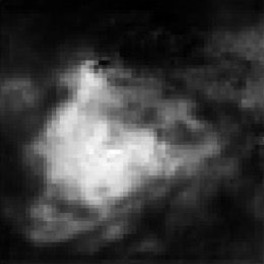

#### Batch size = 16

In [ ]:
storms = ['fgi', 'gkf', 'pjj']
hurricane_dataset = ConcatDataset([HurricaneDatasetImage(image_folder=f'images/{storm}', image_size=(64, 64), channels=1) for storm in storms ])


train_size = int(0.8 * len(hurricane_dataset))
val_size = len(hurricane_dataset) - train_size

train_dataset = Subset(hurricane_dataset, range(train_size))
val_dataset = Subset(hurricane_dataset, range(train_size, len(hurricane_dataset)))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

In [ ]:
model = Seq2SeqImage(num_channels=1, num_kernels=64,
kernel_size=(3, 3), padding=(1, 1), activation="relu",
frame_size=(64, 64), num_layers=3).to(device)

optim = Adam(model.parameters(), lr=2e-4)

criterion = nn.L1Loss(reduction='sum')

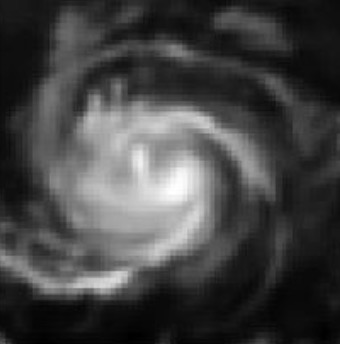

In conclusion, we have decided to plot the images with a batch size of 8 and a learning rate of 1e-4. We will also train the model on 3 different storms since the results and tradeoffs between training on 1 and 5 storms are not significant enough to justify the extra computational cost. We decided to not use a ResNet50 layer in the ConvLSTM since the results were not significantly better than the ConvLSTM alone. And we predict 1 image at a time since the results were not significantly better than predicting 3 images at a time.